ADS Sample Notebook.

Copyright (c) 2019 Oracle, Inc. All rights reserved. Licensed under the Universal Permissive License v 1.0 as shown at https://oss.oracle.com/licenses/upl.

***
# <font color=red>Introduction to Model Evaluation with ADSEvaluator</font>
<p style="margin-left:10%; margin-right:10%;">by the <font color=teal> Oracle ADS Team </font></p>

***

# Notebook Overview
In this notebook demo, we will demonstrate the capabilities of __ADSEvaluator__, the ML evaluation component of OCI's Accelerated Data Science (ADS) package. We will show how it can be used for the evaluation of any general class of supervised machine learning models, as well as comparison amongst models within the same class.   

Specifically, we will focus on binary classification using an imbalanced data set, multi-class classification using a synthetically generated data set consisiting of 3 equally distributed classes and lastly regression using a synthetically generated data set with positive targets. The training would be done using a standard library, and subsequently, the models would be evaluated using __ADSEvaluator__.

## Prerequisites:
 - Experience with specific topic: Novice
 - Professional experience: None
 
This overview is intended for beginners in the fields of statistics, data science and machine learning. No formal professional experience is needed to follow along, but the reader should have some basic knowledge of the programming language Python, and introductory statisitcal terminology. 

## Business Uses:
Model evaluation and interpretation are equally as important as training, as training for the wrong metric or evaluator can yield useless models. Therefore it is essential for any business problem to identify the way they want to decide how good a model is versus another:
 - When the medical industry performs a diagnosis, they do not want a model that only does well in accuracy, it needs a model that has virtually 0 false negatives, even if it's at great cost to the false positives. Or, in a multiclass example, they may want to diagnose a later stage of a disease rather than an earlier.
 - The airline industry wants to predict the delay of any given flight. In this case they may want to use a squared loss function such that greater errors are punished by a lot more (such as rmse), rather than an absolute error (such as hamming loss).
 - A delivery company, on the other hand, may just want to optimize purely for accuracy when anticipating where to have products distributed.

## Objectives:
By the end of this tutorial, we will know how to:
 - <a href='#setup'>0. Setup</a>
 - <a href='#eval'>1. Creating `ADSEvaluator` Objects</a> using the ADS workflow
     - <a href='#bin'>1.1 Binary Classification Evaluator</a>
     - <a href='#multi'>1.2 Multiclass Classification Evaluator</a>
     - <a href='#reg'>1.3 Regression Evaluator</a>
 - <a href='#plot'>2. Display Plots</a> for any ADSEvaluator object.
 - <a href='#met'>3. Display Metrics</a> for any ADSEvaluator object.
 - <a href='#raw'>4. Output Raw Metrics</a> for any ADSEvaluator object.
 - <a href='#admod'>5. Add and Delete Models</a> for any ADSEvaluator object.
 - <a href='#admet'>6. Add and Delete Metrics</a> for any ADSEvaluator object.
 - <a href='#cost'>7. Calculate the Cost</a> for a Binary Classification ADSEvaluator object.
 - <a href='#ref'>References</a>
 ***
 <a id='setup'></a>

## Setup
Before we get going, import the following packages:

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager

import ads.environment.ml_runtime
from ads.dataset.factory import DatasetFactory

import ads
ads.set_debug_mode(True)

Using TensorFlow backend.


<a id='eval'></a>
<a id='bin'></a>
## Binary Classification

The next few cells will demonstrate one way to create and binary classification evaluator object. However, each of these cells are modular and can be interchanged with your favorite alternative and  weaved back in.

#### Getting Data

For this example, we want to predict whether or not a given transaction may be fraudulent based off of a vareity of columns.

The data we are going to use is stored on Oracle Cloud Infrastructure Object Storage. OCI Object Storage is a performant hot storage option for data files. We created a pre-authenticated request to access the relevant datafile. You should be able to download the file directly at the URL listed below.

We're going to use the DatasetFactory object from the Oracle Accelerated Data Science (ADS) library to pull the data from object storage. `DatasetFactory.open` creates an ADSDataset type object, which can be used for a variety of visualizations. Here we will pass in the target `anomalous`, as that is the feature we are trying to predict.

In [23]:
binary_fk = DatasetFactory.open("data/oracle_fraud_dataset1.csv", target="anomalous")

Initializing:0.000s
Loading data:0.103s


Generating data sample:0.182s
Building dataset:0.149s
Running data type discovery:1.454s
Calculating co-correlation of features:0.080s


Now that we have data with a set target, we will split it 85/15 for training on our models using the builtin train_test_split function.

In [24]:
train, test = binary_fk.train_test_split(test_size=0.15)
X_train = train.X.values
y_train = train.y.values
X_test = test.X.values
y_test = test.y.values

#### Training Binary Classifiers using Sklearn
Sklearn is one well-known Python library for training various kinds of machine learning models. We use it here to train two classifiers:
 - __Logistic regression__: Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable, although many more complex extensions exist. In regression analysis, logistic regression (or logit regression) is estimating the parameters of a logistic model (a form of binary regression)
 - __Random Forest__: Random forests are an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

lr_clf = LogisticRegression(random_state=0, solver='lbfgs',
                          multi_class='multinomial').fit(X_train, y_train)

rf_clf = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)

#### Convert model into an ADSModel
The ADSModel class in the ADS package, has a `from_estimator` function that takes as input a fitted estimator and converts it into an ADSModel object. In the case of classification, we need to pass the class labels in the `classes` argument as well. The ADSModel object, as we will show next, will be used for evaluation using the ADSEvaluator object. 

In [6]:
from ads.common.model import ADSModel
bin_lr_model = ADSModel.from_estimator(lr_clf, classes=[0,1])
bin_rf_model = ADSModel.from_estimator(rf_clf, classes=[0,1])

#### Model Evaluations using ADSEvaluator object
To instantiate ADSEvaluator object, two main things we need to pass are:
 - __MLData__: The MLData object for the test set prepared earlier
 - __Models__: The ADSModel objects for the logistic regression and random forest. 

In [7]:
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import MLData

bin_evaluator = ADSEvaluator(test, models=[bin_lr_model, bin_rf_model], training_data=train)

 <a id='plot'></a>
The ADSEvaluator object has a `show_in_notebook()` function, which can be used visualize a variety of machine learning evaluation metrics. For binary classification you can view the following:
 - __pr_curve__: A plot of precision vs recall (the proportion of positive class predictions that were correct vs the proportion of positive class objects that were correctly identified). [Read more](https://en.wikipedia.org/wiki/Precision_and_recall).
 - __roc_curve__: A plot of true positive rate vs false positive rate (recall vs the proportion of negative class objects that were identified incorrectly). [Read more](https://en.wikipedia.org/wiki/Receiver_operating_characteristic).
 - __lift_chart__: A plot of lift vs % baseline positives (cumulative gain/total gain vs predictive positive rate). [Read more](https://en.wikipedia.org/wiki/Lift_(data_mining)). 
 - __gain_chart__: A plot of gain vs % baseline positives (true positive rate or recall vs predictive positive rate). [Read more](http://mlwiki.org/index.php/Cumulative_Gain_Chart).
 - __ks_statistics__: (or the Kolmogorov–Smirnov statistic) A nonparametric plot of the dfference in the distibutions of both labels. [Read more](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test).
 - __normalized_confusion_matrix__: A matrix of the number of actual vs predicted values for each class, normalized by the number of true labels per class (rows). [Read more](https://en.wikipedia.org/wiki/Confusion_matrix).

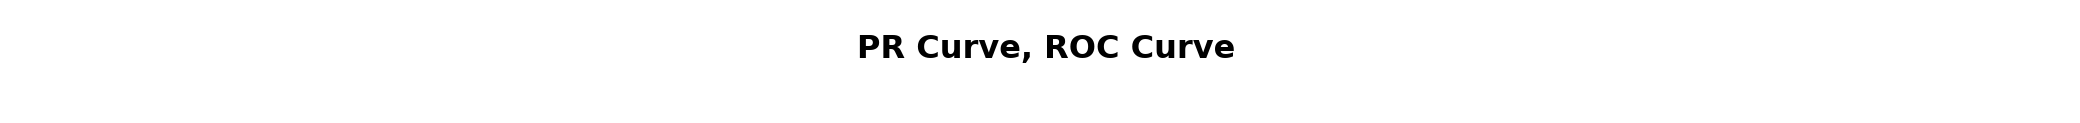

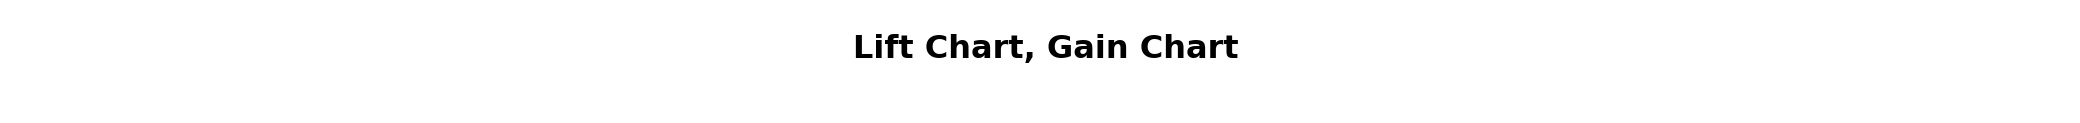

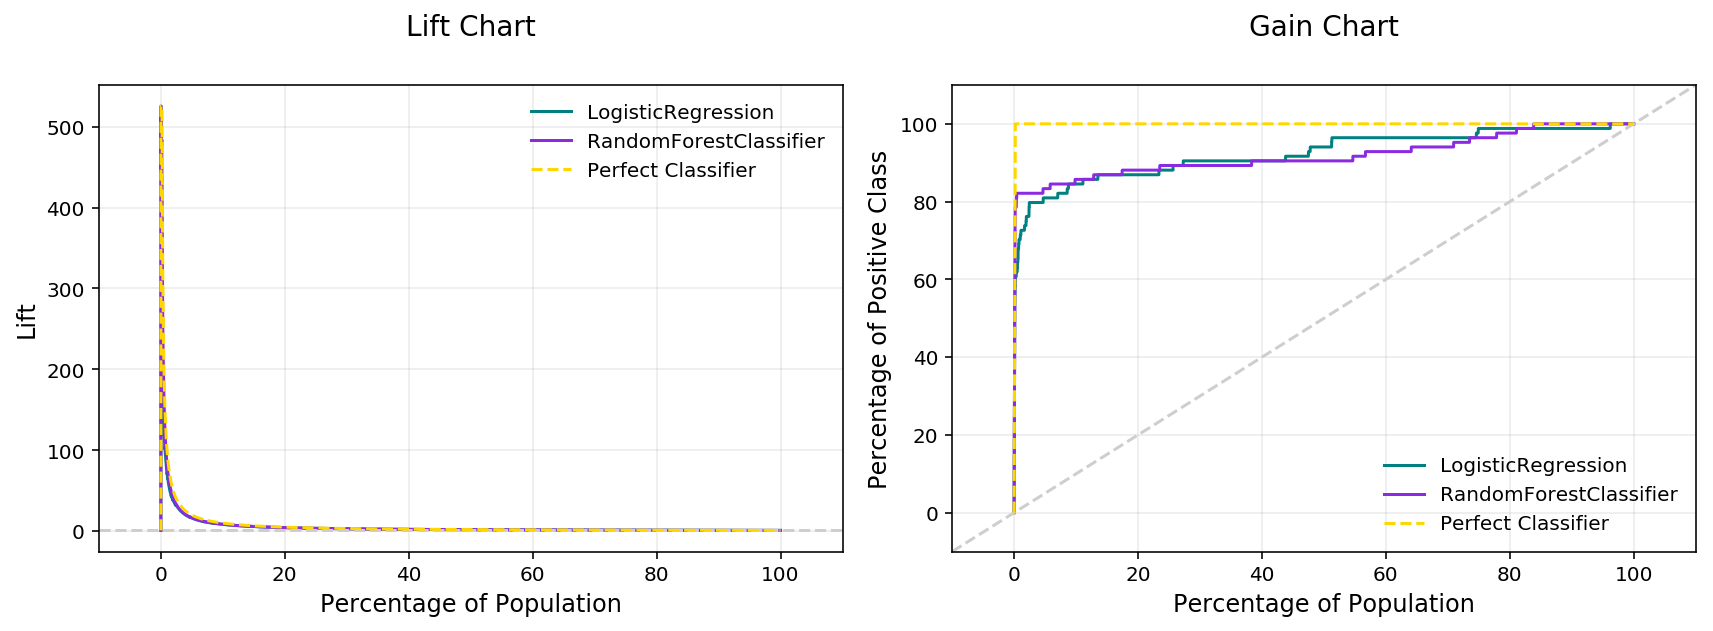

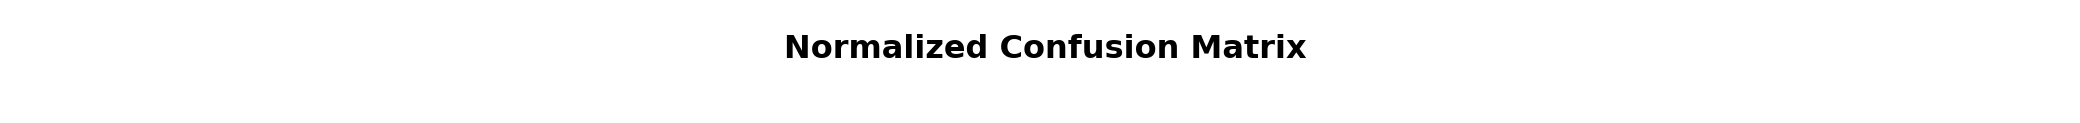

In [7]:
bin_evaluator.show_in_notebook(perfect=True)

 Note on parameters:
 - If `perfect` is set `True`, we plot a perfect classifier for comparison in Lift and Gain charts.
 - If `baseline` is set `True`, we don't include a baseline for the comparison of various plots.
 - If `use_training_data` is set `True`, we plot the evaluations of the training data.
 - If `plots` contains a list of plot types, we plot only those plot types.

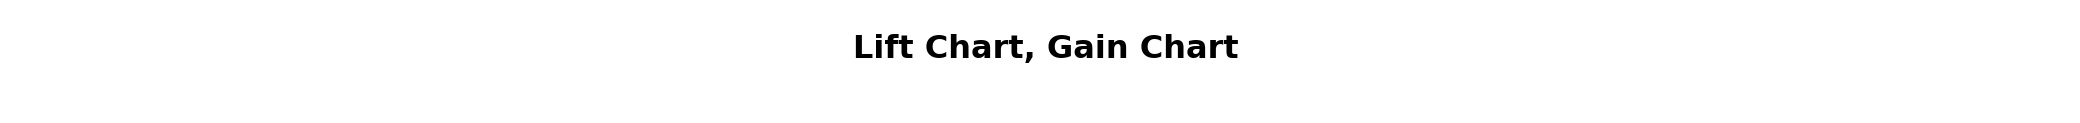

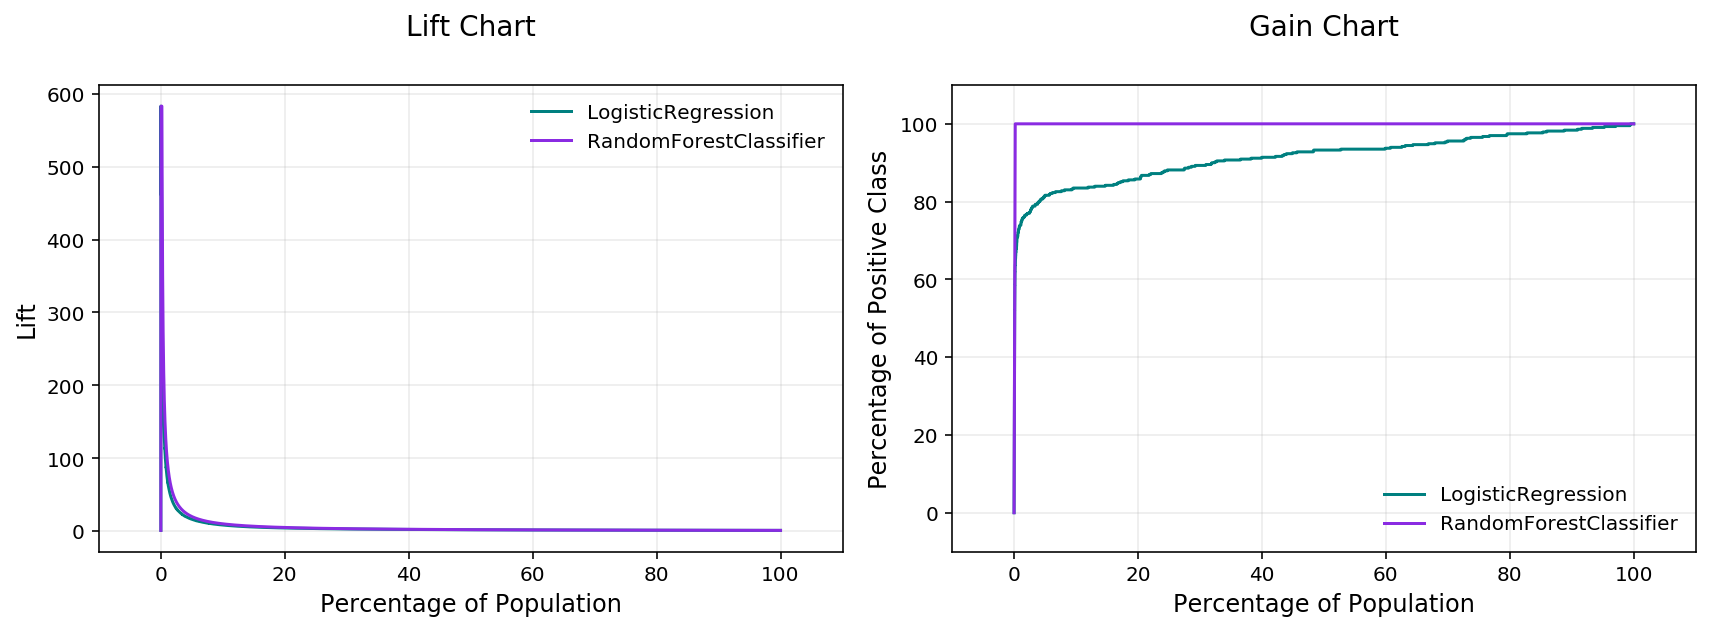

In [8]:
bin_evaluator.show_in_notebook(['gain_chart', 'lift_chart'], baseline=False, use_training_data=True)

 <a id='met'></a>
Further we can compare various metrics using the `metrics` property of the ADSEvaluator object. For binary classification, we can see the following:
 - __accuracy__: Proportion of correctly classified examples.
 - __hamming_loss__: Proportion of incorrectly classified examples.
 - __precision__: Proportion of positive class predictions that were correct.
 - __recall__: Proportion of positive class examples that were correctly identified.
 - __f1__: Harmonic mean of precision and recall
 - __auc__: Area under the ROC. 
 
The metrics in blue are the best for that row of models on testing data. The metrics in yellow are the best for that row of models on training data.

In [9]:
bin_evaluator.metrics

HTML(value='<style  type="text/css" >\n    #T_0ba150ec_3207_11ea_9192_bf189101ffe4  {\n          text-align: r…

HTML(value='<style  type="text/css" >\n    #T_0bad1242_3207_11ea_9192_bf189101ffe4  {\n          text-align: r…

We can select specific metrics as we wish, by extracting them from the Pandas DataFrames `test_evaluations` or `train_evaluations` and subsequently indexing the row `.loc['metric_name']`. For example, we can show only the __precision__.

In [11]:
bin_evaluator.test_evaluations.loc['precision']

LogisticRegression        0.902439
RandomForestClassifier    0.924528
Name: precision, dtype: object

 <a id='multi'></a>
## Multiclass Classification

Our next example will be much of the same, but rather than predicting 2 classes, we will predict 3. We will walk through this much faster.

#### The Data

Here we will use the wine dataset from sklearn. This dataset contains certain features about different wines, and our goal is to predict the type. We can load it in using `ADSDataset Browser` as shown in the following cell.

In [12]:
from ads.dataset.dataset_browser import DatasetBrowser
multi_ds = DatasetBrowser.sklearn().open("wine").set_target("target")

Initializing:0.000s
Loading data:0.076s


Generating data sample:0.071s
Building dataset:0.096s
Running data type discovery:0.337s
Calculating co-correlation of features:0.101s


Now that we have data with a set target, we will split it 85/15 for training on our models using the builtin train_test_split function.

In [13]:
train, test = multi_ds.train_test_split(test_size=0.15)
X_train = train.X.values
y_train = train.y.values
X_test = test.X.values
y_test = test.y.values

#### Training Multi-Class Classifiers using Sklearn
We use sklearn here to train two multi-class classifiers:
 - __Multinomial Logistic Regression__: Multinomial logistic regression is a classification method that generalizes logistic regression to multiclass problems, i.e. with more than two possible discrete outcomes. It is also known as softmax regression, because of the use of a softmax function. The logistic function used in binary logistic regression, is a special case of the softmax function for 2 outcomes. 
 - __Random Forest__: Random forests are an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

lr_clf = LogisticRegression(random_state=0, solver='lbfgs',
                          multi_class='multinomial').fit(X_train, y_train)

rf_clf = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)

#### Convert model into an ADSModel
Similar to the case of binary classification, we need to pass the class labels in the `classes` argument as well. We have 3 classes here, __0__, __1__ and __2__.

In [15]:
from ads.common.model import ADSModel
lr_model = ADSModel.from_estimator(lr_clf, classes=[0,1,2])
rf_model = ADSModel.from_estimator(rf_clf, classes=[0,1,2])

#### Model Evaluations using ADSEvaluator object
Similar to the of binary classification, to instantiate an ADSEvaluator object we need:
 - __MLData__: The MLData object for the test set prepared earlier
 - __Models__: The ADSModel objects for the multinomial logistic regression and random forest.

In [16]:
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import MLData

multi_evaluator = ADSEvaluator(test, models=[lr_model, rf_model])

For multi-class classification you can view the following using `show_in_notebook()`:
 - __confusion_matrix__: A matrix of the number of actual vs predicted values for each class. [Read more](https://en.wikipedia.org/wiki/Confusion_matrix)
 - __pr_curve__: A plot of precision vs recall (the proportion of positive class predictions that were correct vs the proportion of positive class objects that were correctly identified). [Read more](https://en.wikipedia.org/wiki/Precision_and_recall).
 - __roc_curve__: A plot of true positive rate vs false positive rate (recall vs the proportion of negative class objects that were identified incorrectly). [Read more](https://en.wikipedia.org/wiki/Receiver_operating_characteristic).
 - __precision_by_label__: Consider one label as positive class and rest as negative. Compute precision for each, __3__ precision numbers in this example. [Read more](https://en.wikipedia.org/wiki/Precision_(statistics))
 - __recall_by_label__: Consider one label as positive class and rest as negative. Compute recall for each, __3__ recall numbers in this example. [Read more](https://en.wikipedia.org/wiki/Precision_and_recall)
 - __f1_by_label__: Harmonic mean of precision_by_label and recall_by_label. Compute f1 for each, __3__ f1 scores in this examples. [Read more](https://en.wikipedia.org/wiki/F1_score)
 - __jaccard_by_label__: Computes the similaity for each label distribution. [Read more](https://en.wikipedia.org/wiki/Jaccard_index)

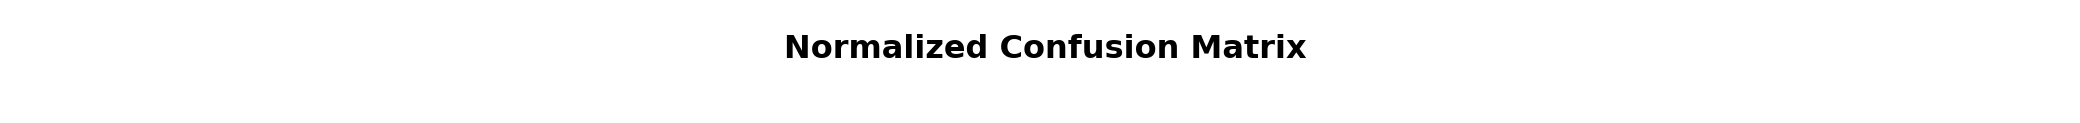

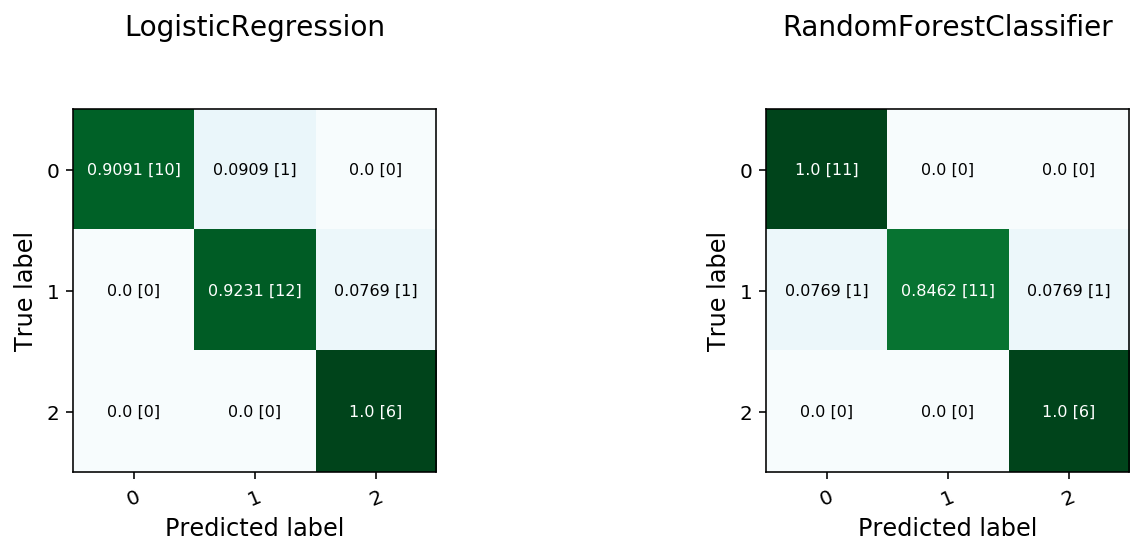

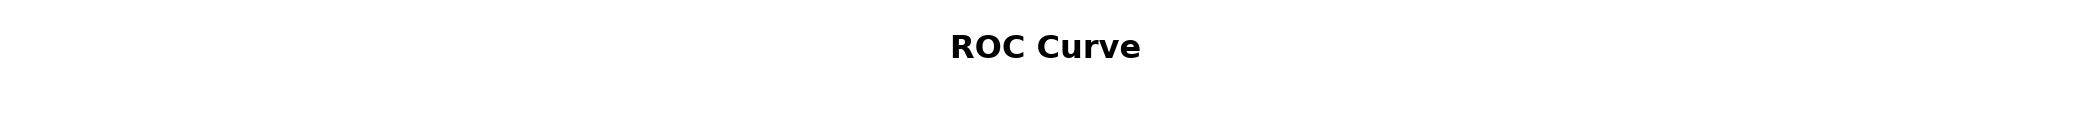

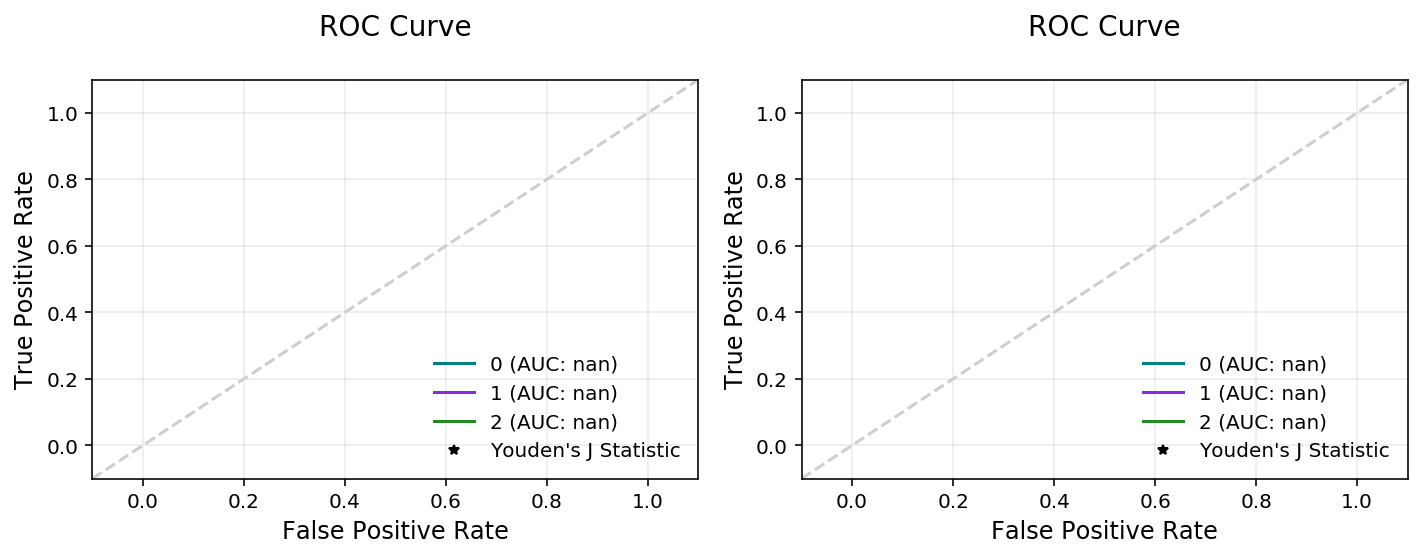

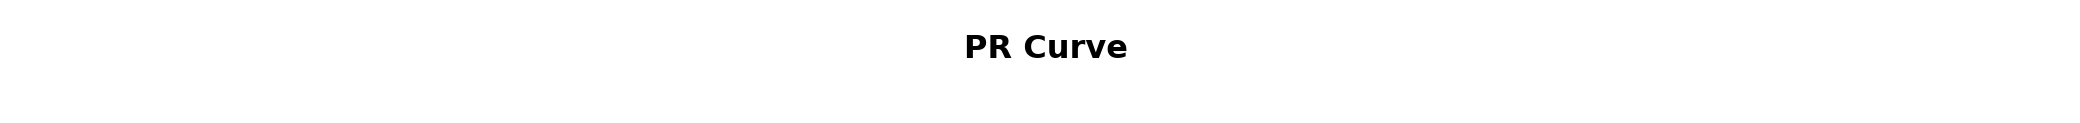

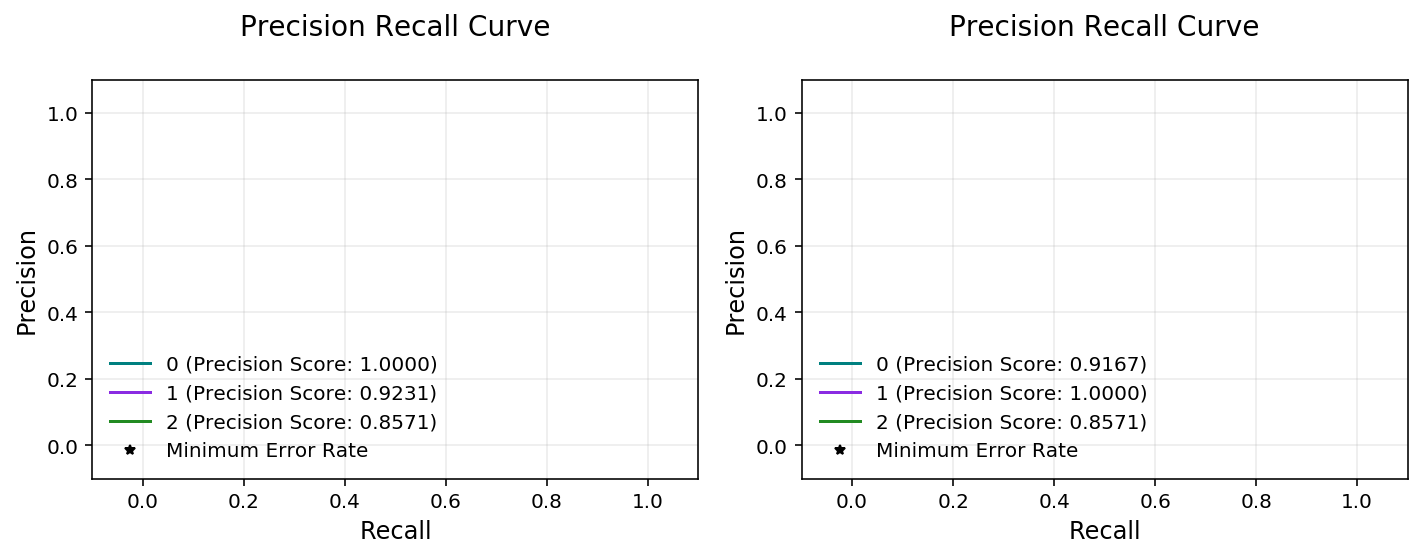

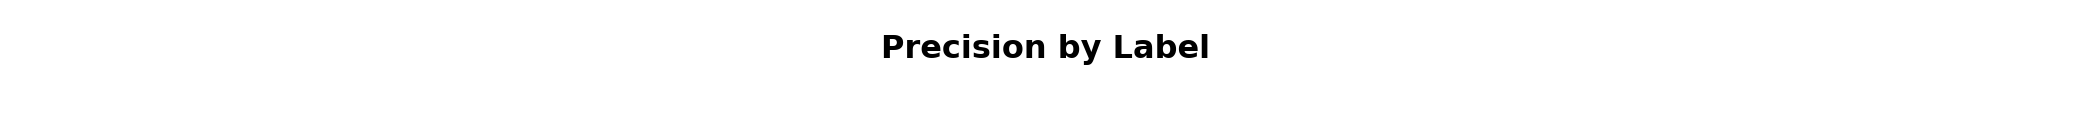

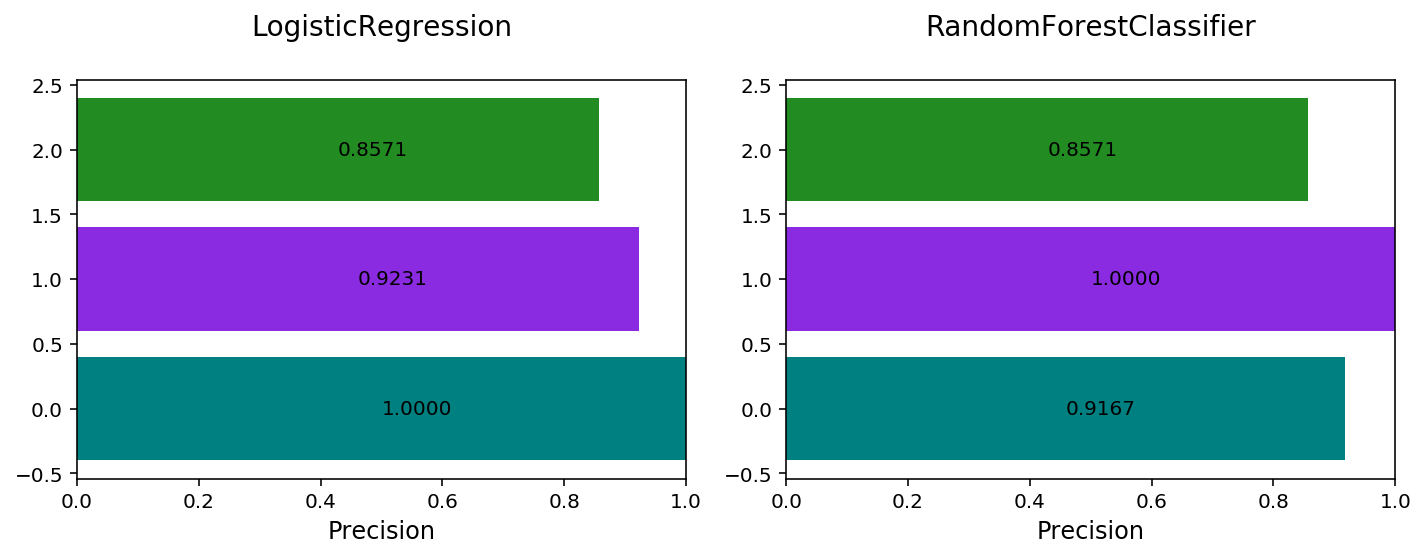

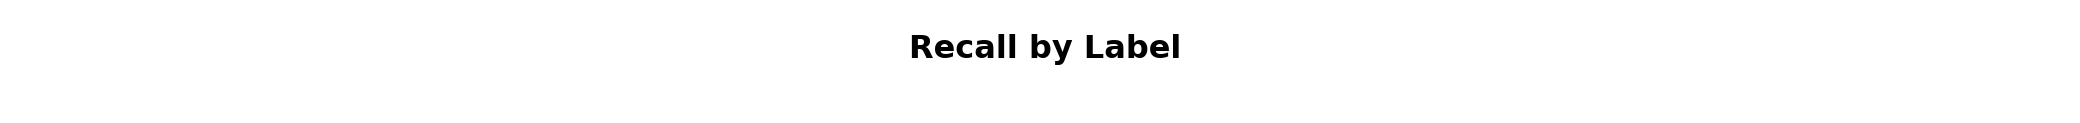

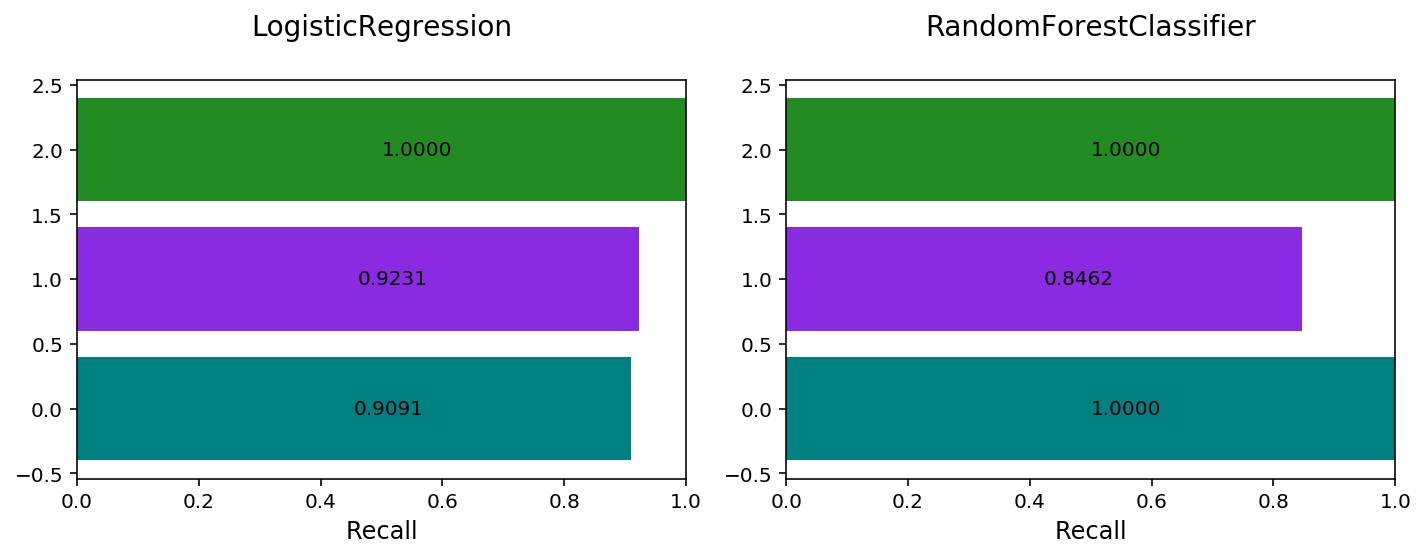

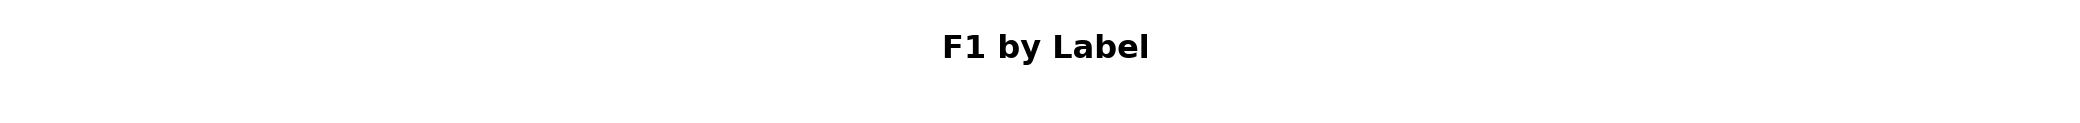

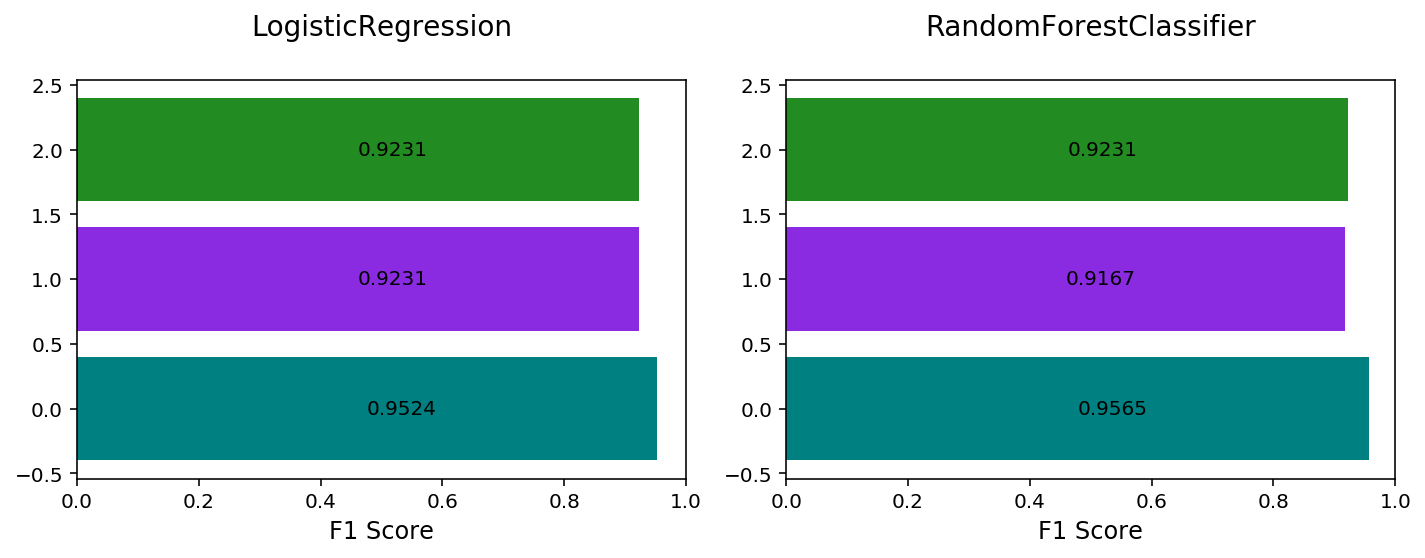

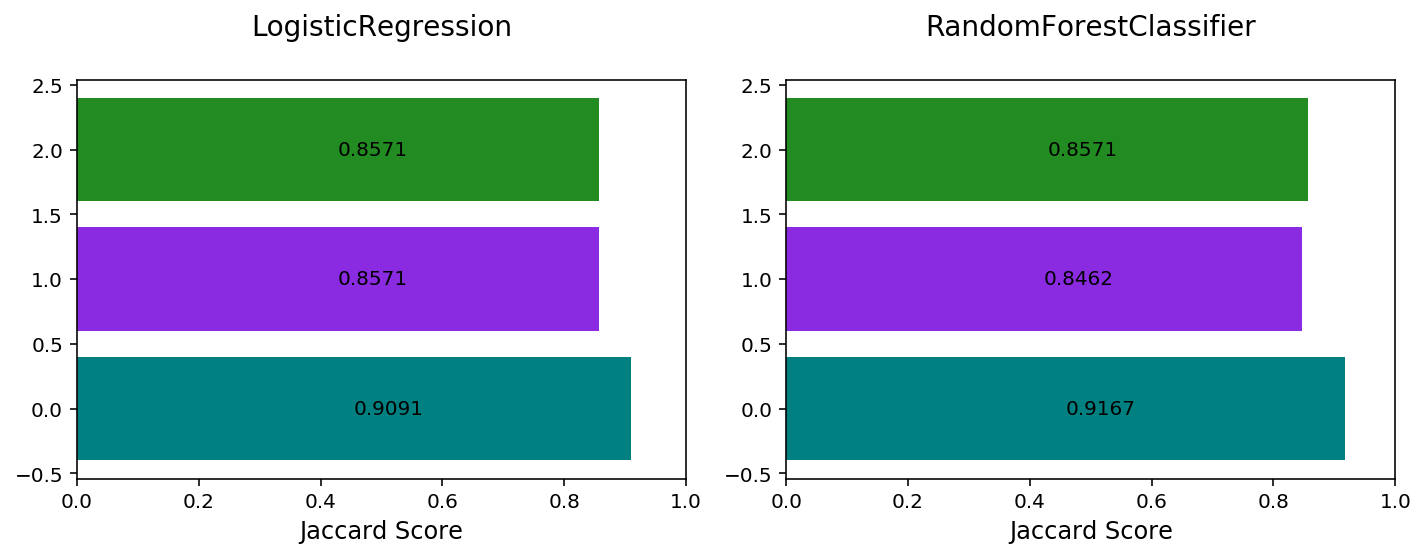

In [16]:
multi_evaluator.show_in_notebook()

For multi-class classification, we can see the following:
 - __accuracy__: Number of correctly classified examples divided by total examples
 - __hamming_loss__: 1 - accuracy
 - __precision_weighted__: Weighted average of __precision_by_label__. Weights are proportional to the number of true instances for each label.
 - __precision_micro__: Global precision. Calculated by using global true positives and false positives.
 - __recall_weighted__: Weighted average of __recall_by_label__. Weights are proportional to the number of true instances for each label.
 - __recall_micro__: Global recall. Calculated by using global true positives and false negatives. 
 - __f1_weighted__: Weighted average of __f1_by_label__. Weights are proportional to the number of true instances for each label.
 - __f1_micro__: Global f1. Can be calculated by using the harmonic mean of __precision_micro__ and __recall_micro__.

All of these metrics can be computed directly from the confusion matrix. 

In [17]:
multi_evaluator.metrics

HTML(value='<style  type="text/css" >\n    #T_23f96274_3207_11ea_9192_bf189101ffe4  {\n          text-align: r…

<a id='reg'></a>

## Regression

Finally, we will run through another example of building an evaluator object, but this time for a regression problem.

#### The Data

We will load yet another dataset from sklearn: the Boston Housing Prices dataset. The target of this problem is to guess the price of a house in boston based off of several features about it.

In [18]:
reg_ds = DatasetBrowser.sklearn().open("boston").set_target("target")

Initializing:0.000s
Loading data:0.085s


Generating data sample:0.052s
Building dataset:0.074s
Running data type discovery:0.407s
Calculating co-correlation of features:0.095s


Now that we have our data loaded and target set, we will perform an 85/15 train-test split of data. 

In [19]:
train, test = reg_ds.train_test_split(test_size=0.15)
X_train = train.X.values
y_train = train.y.values
X_test = test.X.values
y_test = test.y.values

#### Training Regression Models using Sklearn
We use sklearn here to train two regression models:
 - __Linear Regression__:  Linear regression is a linear approach to modeling the relationship between a scalar response and one or more predictor variables. Linear regression models try to minimize the sum of the squares of the residuals, in the loss function.
 - __Lasso__: Lasso (least absolute shrinkage and selection operator) is a regression analysis method that performs both variable selection and regularization in order to enhance the prediction accuracy and interpretability of the statistical model it produces. Mathematically, it applies the L1-penalty to least squares of residuals loss function in linear regression.

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

lin_reg = LinearRegression().fit(X_train, y_train)

lasso_reg = Lasso(alpha=0.1).fit(X_train, y_train) 

#### Convert model into an ADSModel
In the case of regression, we only need to pass the fitted estimators (regression models in this case).

In [21]:
from ads.common.model import ADSModel
lin_reg_model = ADSModel.from_estimator(lin_reg)
lasso_reg_model = ADSModel.from_estimator(lasso_reg)

#### Model Evaluations using ADSEvaluator object
Like before, the ADSEvaluator object needs two main things for instantiation:
 - __MLData__: The MLData object for the test set prepared earlier
 - __Models__: The ADSModel objects for the linear regression and lasso regression.

In [22]:
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import MLData

reg_evaluator = ADSEvaluator(test, models=[lin_reg_model, lasso_reg_model])

For regression you can view the following using `show_in_notebook()`:
 - __observed_v_predicted__: Plot of the observed, or actual values against our predicted values output by our models.
 - __residuals_qq__: Quantile-quantile plot between residuals and quantiles of a standard normal distribution. Should be very close to a straight line for a good model. 
 - __residuals_vs_predicted__: Plot of Residuals vs Predicted values. This should not carry a lot of structure in a good model.
 - __residuals_vs_observed__: Plot of Residuals vs Observed values. This, too, should not carry a lot of structure in a good model.

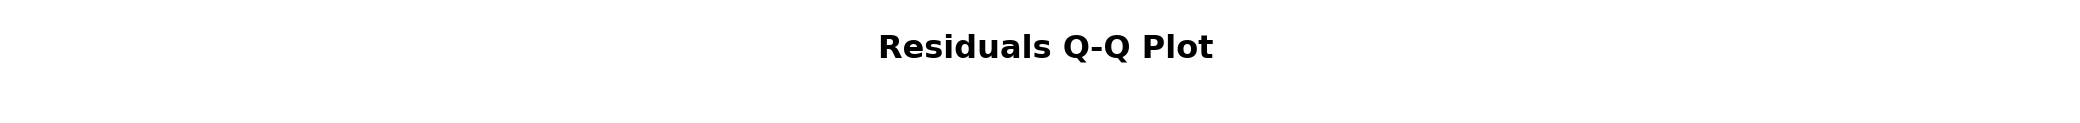

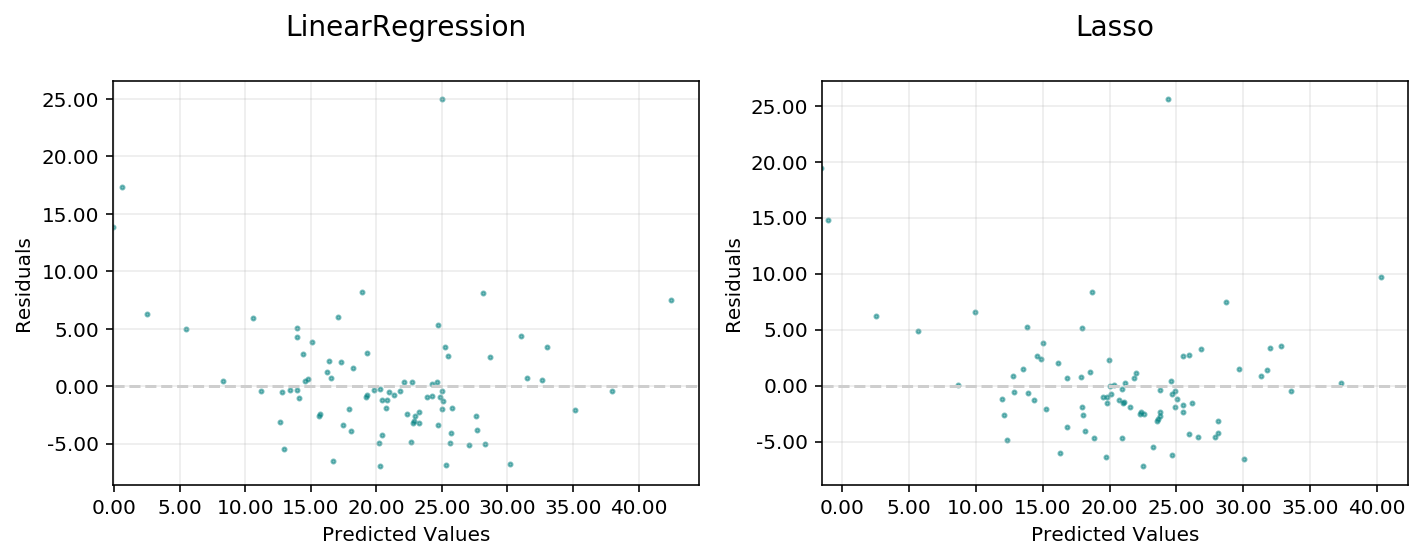

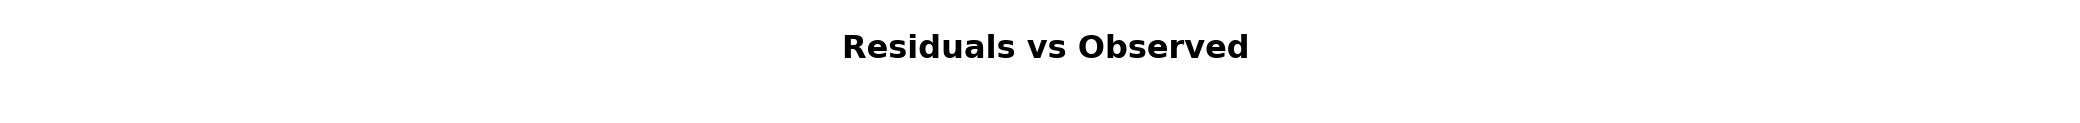

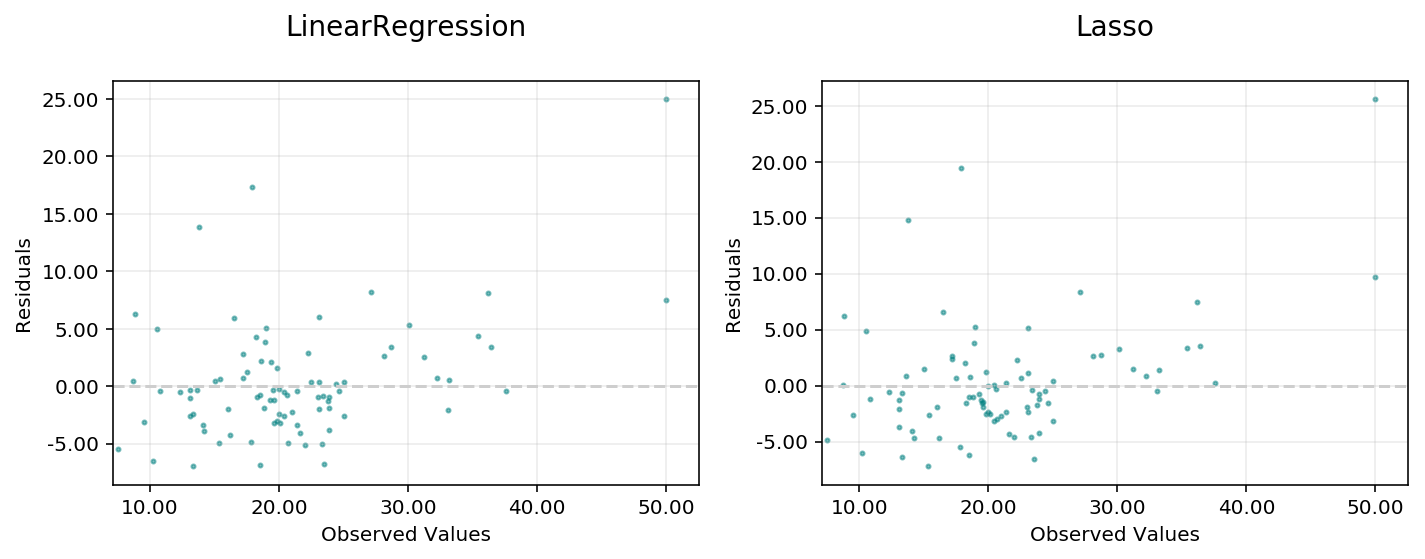

In [23]:
reg_evaluator.show_in_notebook()

For regression, we can use the `.metrics` property to see the following:
 - __r2_score__: Also known as __coefficient of determination__, is the proportion of the variance in the dependent variable that is predictable from the independent variables. [Read more](https://en.wikipedia.org/wiki/Coefficient_of_determination)
 - __explained_variance_score__: Variance of the model's predictions. Mean of the squared difference between the  predicted values and the true mean of the data. [Read more](https://en.wikipedia.org/wiki/Explained_variation)
 - __mean_squared_error__: Mean of the squared difference between the true values and predicted values. [Read More](https://en.wikipedia.org/wiki/Mean_squared_error)
 - __root_mean_squared_error__: Square root of __mean_squared_error__. [Read more](https://en.wikipedia.org/wiki/Root-mean-square_deviation)
 - __mean_absolute_error__: Mean of the absolute difference between the true values and predicted values. [Read more](https://en.wikipedia.org/wiki/Mean_absolute_error)
 - __mean_residuals__: Mean of the difference between the true values and predicted values. [Read more](https://en.wikipedia.org/wiki/Errors_and_residuals)

In [24]:
reg_evaluator.metrics

HTML(value='<style  type="text/css" >\n    #T_fa9c09a8_fc04_11e9_96b6_38f9d3382bd9  {\n          text-align: r…

 <a id='raw'></a>
## Raw Metrics

Now that we have generated various types of evaluators and examined the associated plots and metrics, let's dive into a few more advanced features of the Evaluation class.

Going back to our original binary classification, we will pull the raw metrics from our evaluator as a JSON, so that we can save it, export it to other packages, or do anything else we like.

In [25]:
bin_evaluator.raw_metrics

{'LogisticRegression': {'model_name': 'LogisticRegression',
  'classes': [0, 1],
  'positive_class': 1,
  'y_true': 4       0
  5       0
  7       0
  8       0
  33      0
  36      0
  37      0
  46      0
  52      0
  54      0
  55      0
  59      0
  61      0
  65      0
  73      0
  84      0
  86      0
  96      0
  99      0
  103     0
  107     0
  108     0
  112     0
  114     0
  149     0
  152     0
  153     0
  156     0
  163     0
  172     0
         ..
  7598    0
  7601    0
  7607    0
  7620    0
  7630    0
  7640    0
  7642    0
  7646    0
  7647    0
  7666    0
  7669    0
  7670    0
  7678    0
  7682    0
  7685    0
  7686    0
  7688    0
  7697    0
  7699    0
  7700    0
  7701    0
  7704    0
  7707    0
  7710    0
  7740    0
  7765    0
  7768    0
  7771    0
  7772    0
  7773    0
  Name: anomalous, Length: 44121, dtype: int64,
  'y_pred': [0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,


 <a id='admod'></a>
## Add and Delete Models to Evaluator Instance

We can also add models later on for evaluation, by using the `add_models([model_list])` function. For example, we just read a paper that said that Decision Tree Classifiers might be better for capturing a part of our data, and we wish to add that to an existing evaluator. Simply add the model:

In [26]:
from sklearn import tree
from ads.common.model import ADSModel

train, _ = binary_fk.train_test_split(test_size=0.15)
X_train = train.X.values
y_train = train.y.values

tree_mod = tree.DecisionTreeClassifier(max_depth=3).fit(X_train, y_train)

bin_tree_model = ADSModel.from_estimator(tree_mod, classes=[0,1])

In [27]:
bin_evaluator.add_models([bin_tree_model])

In [28]:
bin_evaluator.metrics

HTML(value='<style  type="text/css" >\n    #T_fe9636b6_fc04_11e9_bc2c_38f9d3382bd9  {\n          text-align: r…

HTML(value='<style  type="text/css" >\n    #T_fe9c3a02_fc04_11e9_aa7d_38f9d3382bd9  {\n          text-align: r…

Looking at the metrics summary above, this model doesn't seem to have added anything to the metrics we are interested in. Therefore, we may as well remove this model to de-clutter our output. Simply delete it:

In [29]:
bin_evaluator.del_models(['DecisionTreeClassifier'])

In [30]:
bin_evaluator.metrics

HTML(value='<style  type="text/css" >\n    #T_feb6e65e_fc04_11e9_b7ba_38f9d3382bd9  {\n          text-align: r…

HTML(value='<style  type="text/css" >\n    #T_febd08fe_fc04_11e9_8a7b_38f9d3382bd9  {\n          text-align: r…

 <a id='admet'></a>
## Add and Delete Custom Metrics from Evaluator Instance

Just as we can add and delete models, we can add and delete metrics. This is for those problems that require esoteric and specific metrics not yet supported by the Evaluator class. For example, with our highly imbalanced dataset of fraudulent credit card purchases, we might find that the F2 score is more relevant than the F1 score. This is a simple addition. We can define any function we would like and pass it into the evaluator via `add_metrics`. This function will get the true values and the predicted values from our model, and put it right into our `evaluator.metrics` output.

`add_metrics` accepts multiple functions passed in as a list. To demonstrate this, we will also pass in a less sophisticated metrics that tells us the number of correct predictions, a sort of unnormalized accuracy, as maybe that is relevant for some users.

In [31]:
from ads.evaluations.evaluator import ADSEvaluator
from sklearn.metrics import fbeta_score
def func1(y_true, y_pred):
    return sum(y_true == y_pred)
def func2(y_true, y_pred):
    return fbeta_score(y_true, y_pred, 2)
bin_evaluator.add_metrics([func1, func2], ["Total True", "F2 Score"])

In [32]:
bin_evaluator.metrics

HTML(value='<style  type="text/css" >\n    #T_fef1db24_fc04_11e9_b155_38f9d3382bd9  {\n          text-align: r…

HTML(value='<style  type="text/css" >\n    #T_fef7b3be_fc04_11e9_a520_38f9d3382bd9  {\n          text-align: r…

These metrics have been interesting, but ultimately didn't add much, let's delete them from our evaluator.

In [33]:
bin_evaluator.del_metrics(["Total True", "F2 Score"])

In [34]:
bin_evaluator.metrics

HTML(value='<style  type="text/css" >\n    #T_ff106f8a_fc04_11e9_8b72_38f9d3382bd9  {\n          text-align: r…

HTML(value='<style  type="text/css" >\n    #T_ff160e06_fc04_11e9_9257_38f9d3382bd9  {\n          text-align: r…

 <a id='cost'></a>
## Calculate Cost

This builtin function helps you to evaluate your binary classification model based on your own weighting of the problem. If true positives are really important and false positives are less important in some sort of medical diagnosis for example, you can use this function to quantify that difference.

The function requires 4 parameters: `tn_weight`, `fp_weight`, `fn_weight`, `tp_weight`, which of course represent the weightings of the 4 values of a binary confusion matrix. See some example distributions below:

In [35]:
# we dont care about the type of error, we just want the number of mistakes
bin_evaluator.calculate_cost(0,1,1,0)

model  cost
0      LogisticRegression    51
1  RandomForestClassifier    39

We want a 100-1 ratio of false positives to false negatives. Meaning we would much rather have 99 positive estimations that were wrong, than 1 negative estimation that is wrong. Here we can see that while Logistic Regression won out on pure accuracy, the Random Forest Classifier was actually better for the cases we care about.

In [36]:
bin_evaluator.calculate_cost(0,1,0.01,0)

model  cost
0      LogisticRegression  4.47
1  RandomForestClassifier  5.34

## Summary
In this notebook, we demonstrated the evaluation capabilities of OCI's Accelerated Data Science library through the use of the __ADSEvaluator__ object contained inside the package. Concretely, we focused on three common machine learning use cases, binary classification, multi-class classification and regression. We trained multiple models for each use case using the Scikit-learn library, and demonstrated how __ADSEvaluator__ works across different classes of ML problems and how it evaluates multiple models within the same class.   

In future, we plan to add more sophisticated visualizations and metrics to support a more comprehensive evaluation. 

 <a id='ref'></a>
## References
* Tibshirani, Robert. [Regression shrinkage and selection via the lasso.](https://rss.onlinelibrary.wiley.com/doi/abs/10.1111/j.2517-6161.1996.tb02080.x) Journal of the Royal Statistical Society: Series B (Methodological) 58.1 (1996): 267-288.
* Pedregosa, Fabian, et al. [Scikit-learn: Machine learning in Python.](http://jmlr.csail.mit.edu/papers/v12/pedregosa11a.html) Journal of machine learning research 12.Oct (2011): 2825-2830.